In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef
from utils import create_mask as cm
from utils import ed_plotting as eplt

# load GPU
gpu_id = '1'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

from models.poissonian_gp import EbinPoissonModel

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# control speed by modifying resolution of healpix plots
n_pixels = 40 # 160 is our best choice
xsize = 200 # 2000 is our best choice (but slow)

In [3]:
# load SVI fit results (these should be the only parameters that you are loading)
sim_seeds = np.arange(1000,1010)

# name of the synthetic directory
sim_name = 'canon_g1p2_ola_v2'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 11
svi_id = 7840 # (24,25) =  (no outer roi, outer roi)
sim_seed = 1000
svi_seed = 0

In [4]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [5]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    summary.txt
    __init__.py
    settings_7p1234567_5p23457_1p16_-1_11_7840_1000_0.py
    ebin_old10_smp_svi_0.1_20000_mvn_8_1000_0.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_0.p
    ebin10_svi_res_0.1_20000_mvn_8_1000_0.p
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_11_7840_1000_0.cpython-311.pyc


In [6]:
# load data (~7 GB ; ~6.5 min)
seq = pickle.load(open('plotting_data/multi/all_mismodelling_data.p', 'rb'))
temp_sample_dict_list, temp_sample_dict_cmask_list, exp_gp_samples_cart_list, gp_true_cart_list, tot_samples_cart_list, model_residuals_cart_list, mask, mask_p, mask_map_cart = seq

In [7]:
# load real data
temp_dict_list, sim_cart_list = pickle.load(open('plotting_data/multi/temp_dict_list.p', 'rb'))

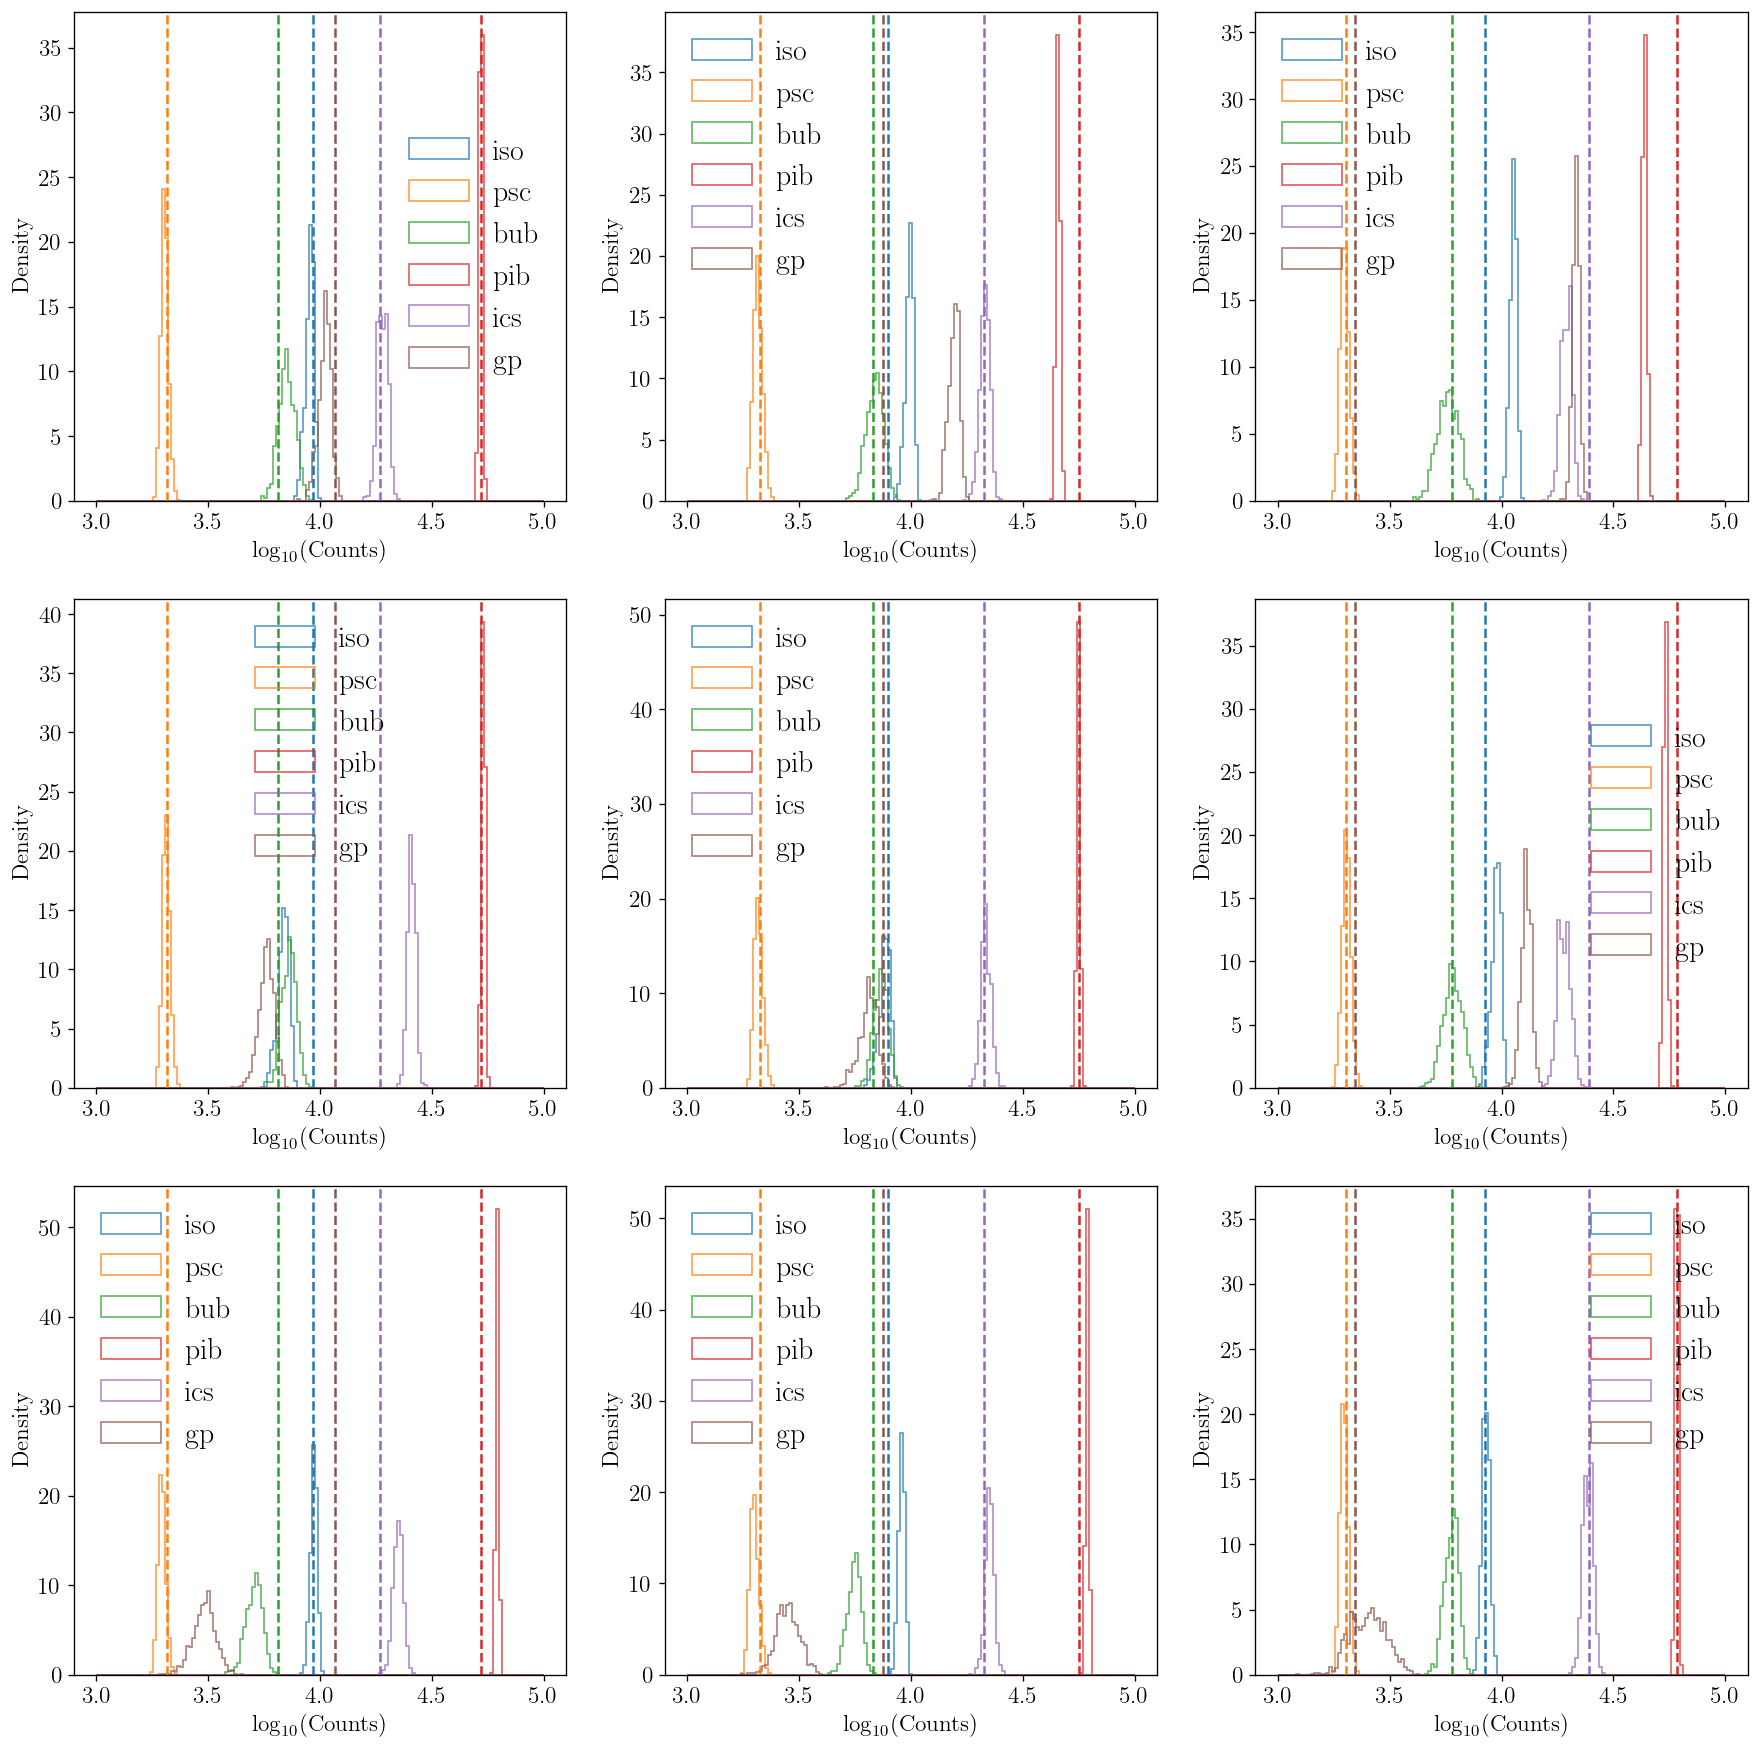

In [8]:
# plot total counts histogram for each fit
# row: different diffuse model ; column: different synthetic dataset

nrows = 3 ; ncols = 3
fig, axes = plt.subplots(figsize=(6*3, 6*3), dpi= 120, nrows = nrows, ncols = ncols)

for i in range(nrows):
    for j in range(ncols):
        mod_id = 10 * (i + 1) + (j + 1)
        temp_sample_dict = temp_sample_dict_list[mod_id]
        temp_dict = temp_dict_list[mod_id]
        temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

        plt.axes(axes[i,j])
        if data_file != 'fermi_data_sum':
            ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = axes[i,j])
        else:
            ef.tot_log_counts_hist(temp_sample_dict, None, None, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False, ax = axes[i,j])

/data/edr76/gce-gp/diffuse_model_tests/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used toge

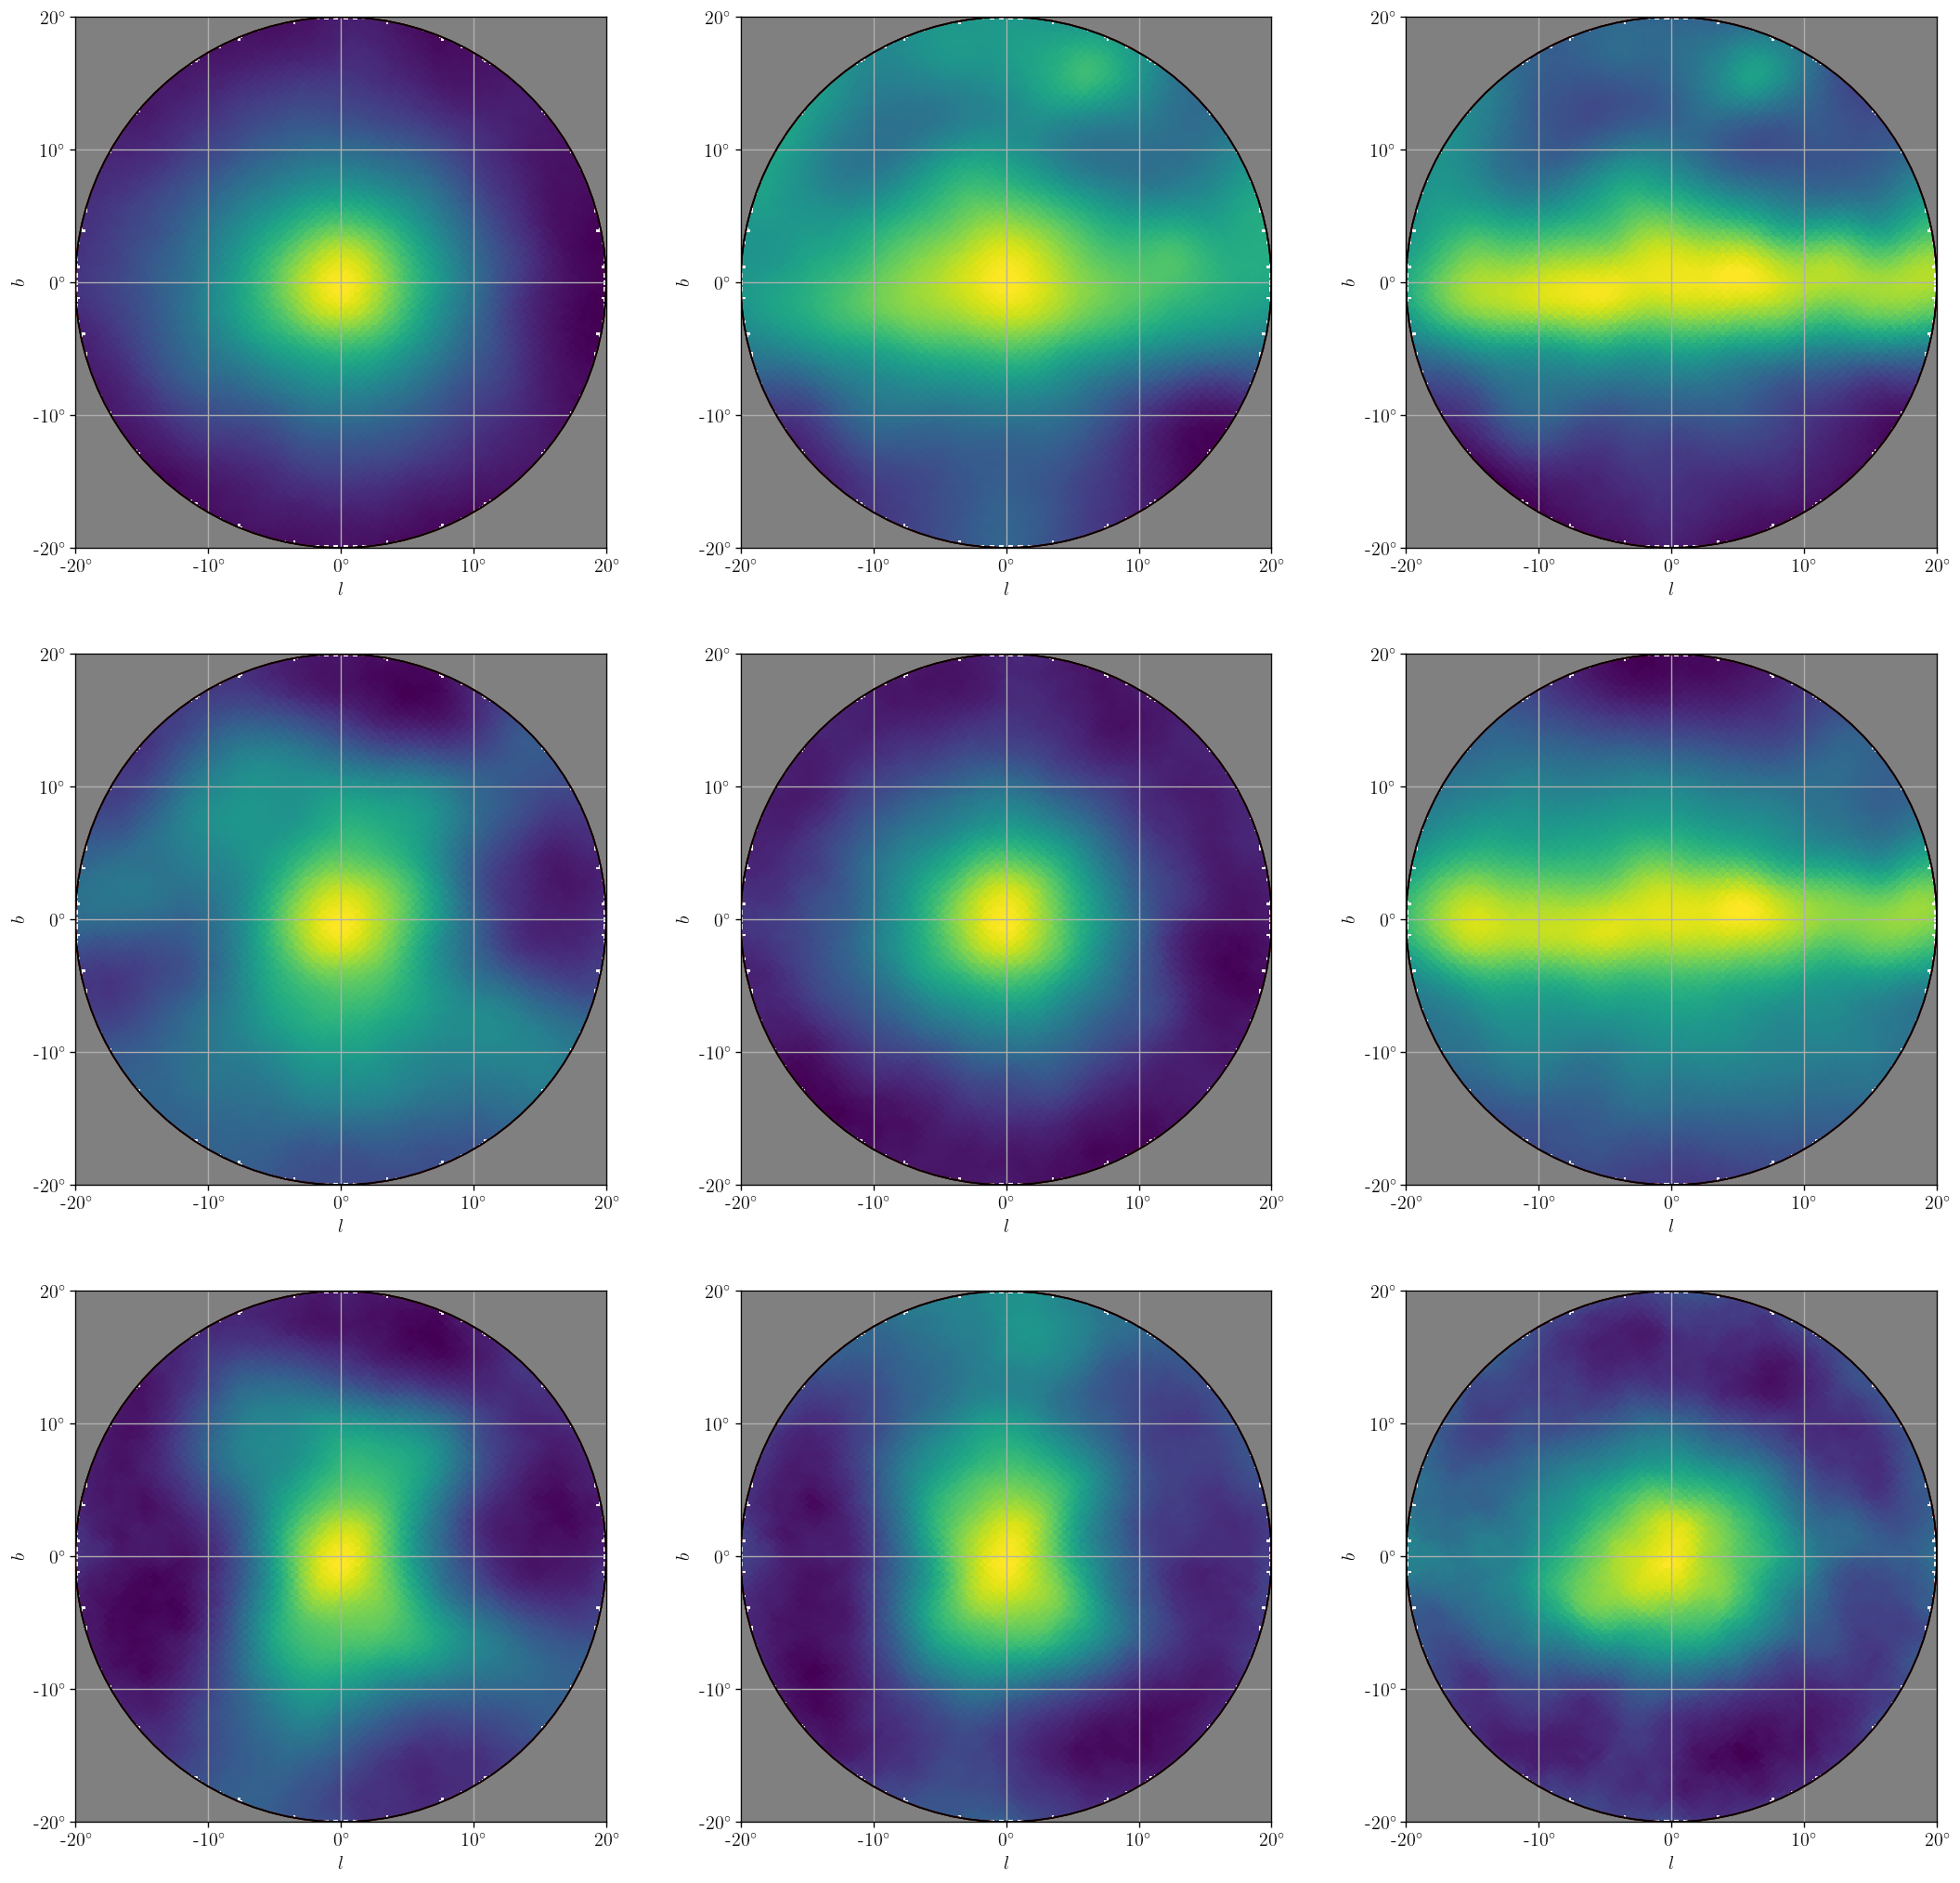

In [9]:
# plot total counts histogram for each fit
# row: different diffuse model ; column: different synthetic dataset

nrows = 3 ; ncols = 3
fig, axes = plt.subplots(figsize=(6*3, 6*3), dpi= 120, nrows = nrows, ncols = ncols)

c = 0
for i in range(nrows):
    for j in range(ncols):
        c += 1

        mod_id = 10 * (i + 1) + (j + 1)
        temp_sample_dict_cmask = temp_sample_dict_cmask_list[mod_id]

        plt.axes(axes[i,j])
        q = np.percentile(temp_sample_dict_cmask['gp'], 50, axis = 0)
        m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
        eplt.inner_roi_map(m, title = None, vmin = None, vmax = None, subplot = int(str(nrows) + str(ncols) + str(c)), 
            cbar = False, 
            xsize = xsize)

In [10]:
n_pixels = 160
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = n_pixels)

# cartesian map of masks to keep track of masking for plots
mask_map = np.zeros((~mask_p).sum())
mask_map_cart = ef.healpix_to_cart(mask_map, mask_p, n_pixels = n_pixels, nside = 128, nan_fill = True) # doesn't matter what mask used

Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg


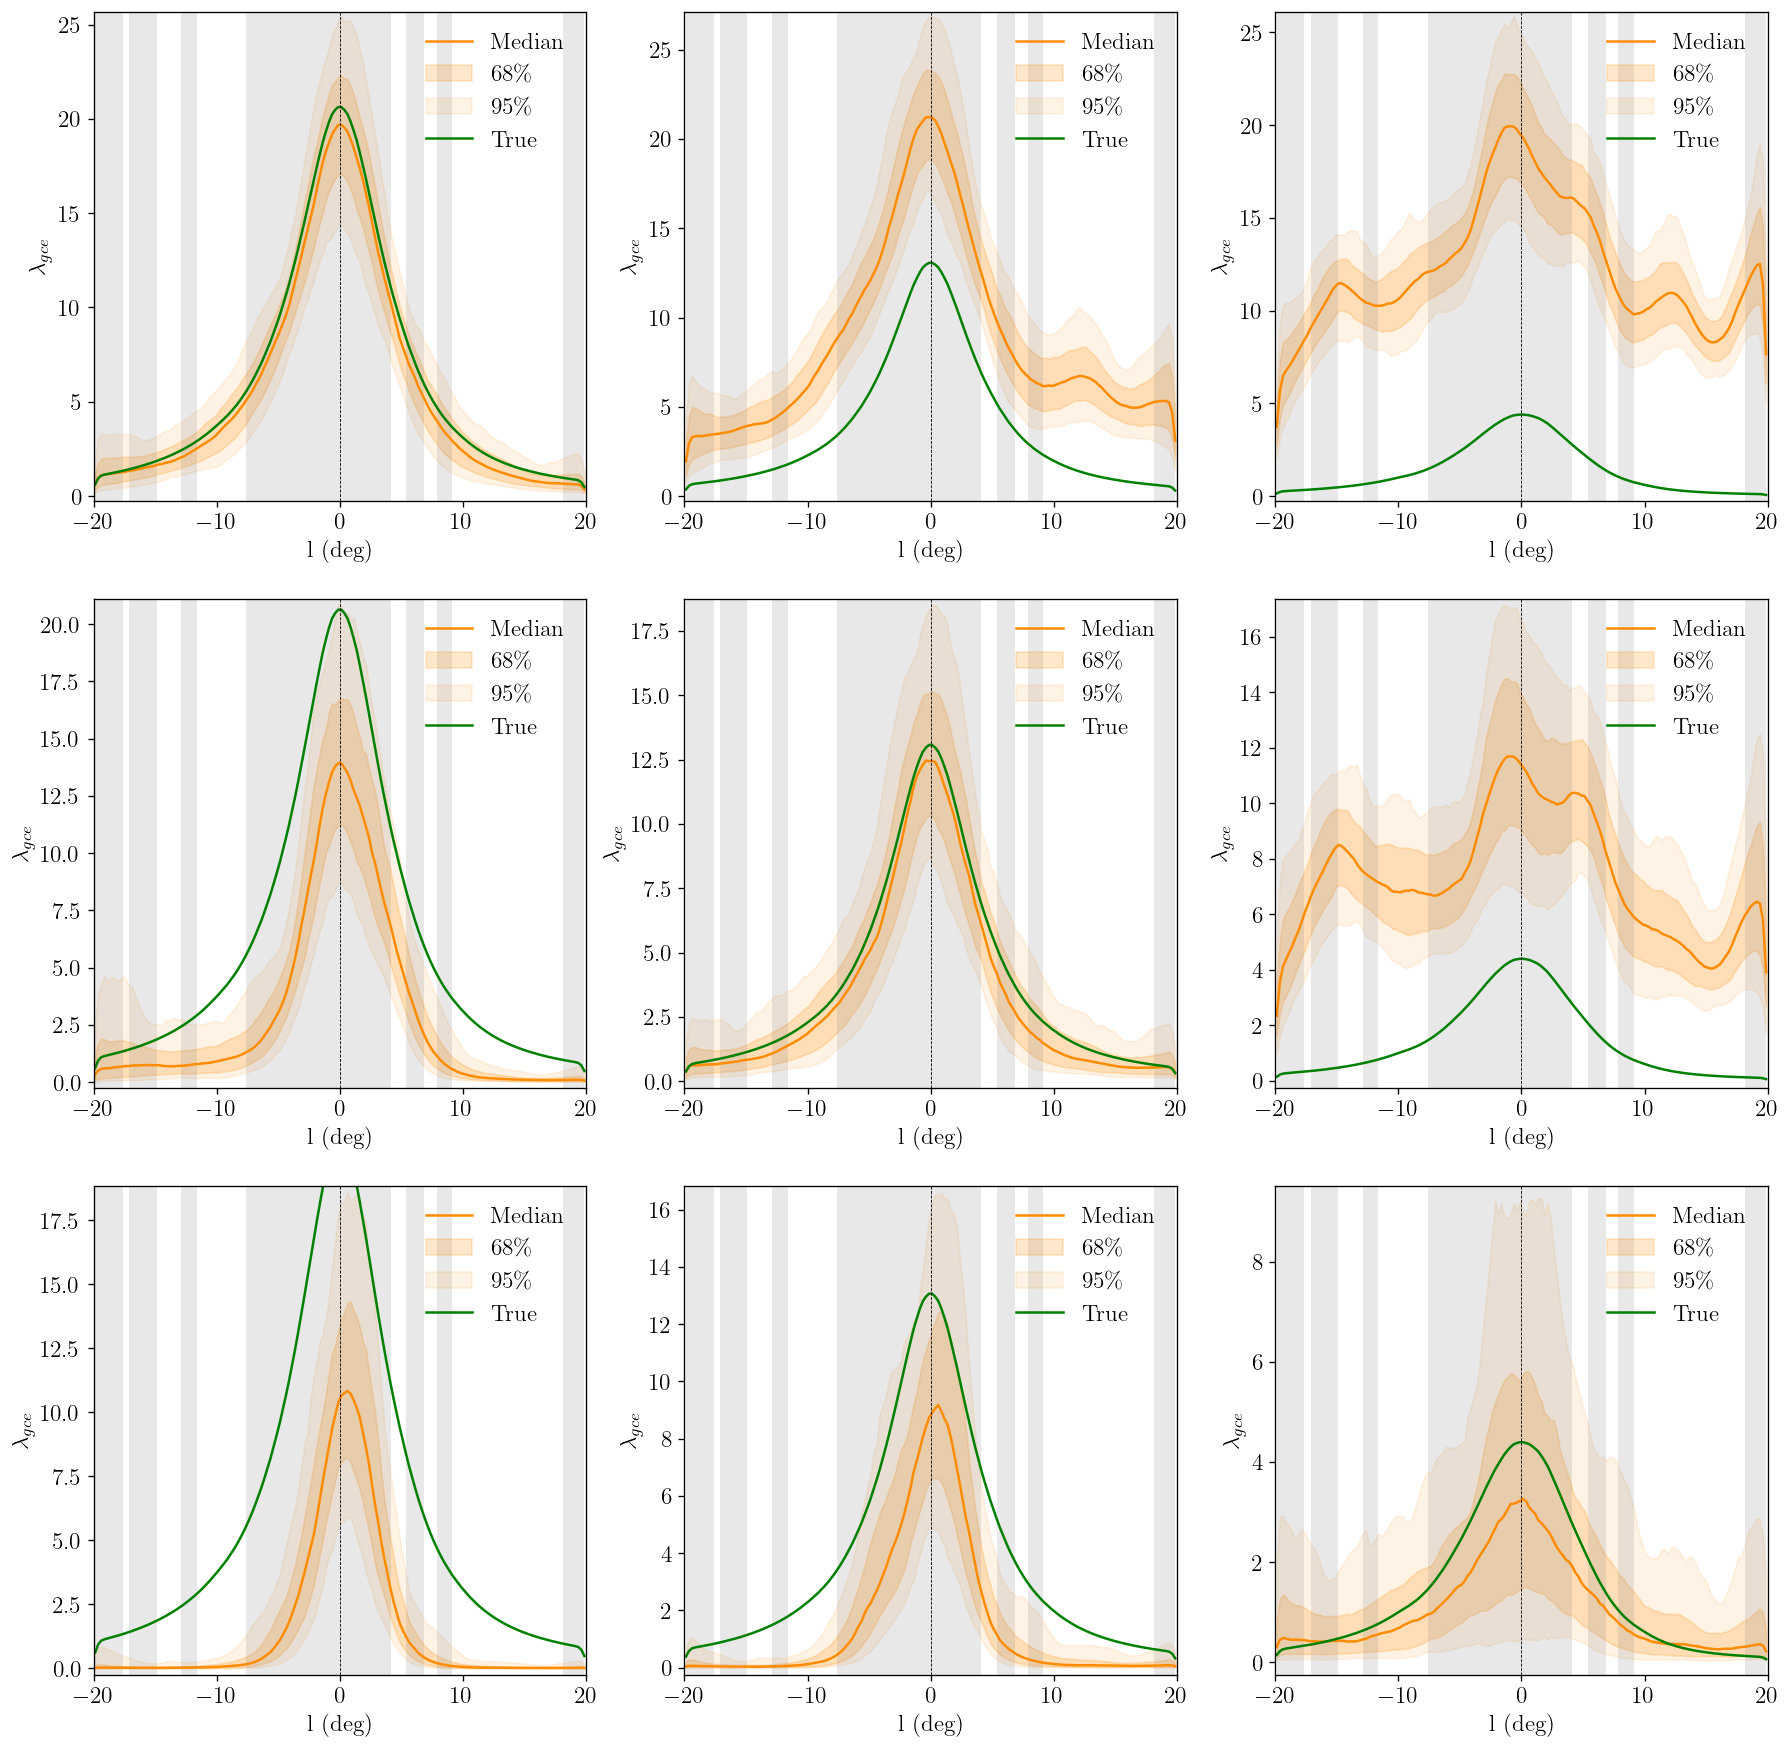

In [12]:
slice_val = 3.2  # y-value of slice

nrows = 3 ; ncols = 3
fig, axes = plt.subplots(figsize=(6*3, 6*3), dpi= 120, nrows = nrows, ncols = ncols)

for i in range(nrows):
    for j in range(ncols):
        mod_id = 10 * (i + 1) + (j + 1)

        exp_gp_samples_cart = exp_gp_samples_cart_list[mod_id]
        gp_true = gp_true_cart_list[mod_id][:5938] # contains 10 copies due to carelessness when creating this

        # 1d slice of GCE
        q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0) # cartesian sample map quantiles
        sim_cart = ef.healpix_to_cart(gp_true[:5938], mask, n_pixels = n_pixels, nside = 128) # simulated rate cartesian map
        raw_cart = None

        plt.axes(axes[i,j])
        eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
            slice_dir = 'horizontal', slice_val = slice_val, 
            mask_map_cart = mask_map_cart,
            n_pixels = n_pixels,
            ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')

Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg


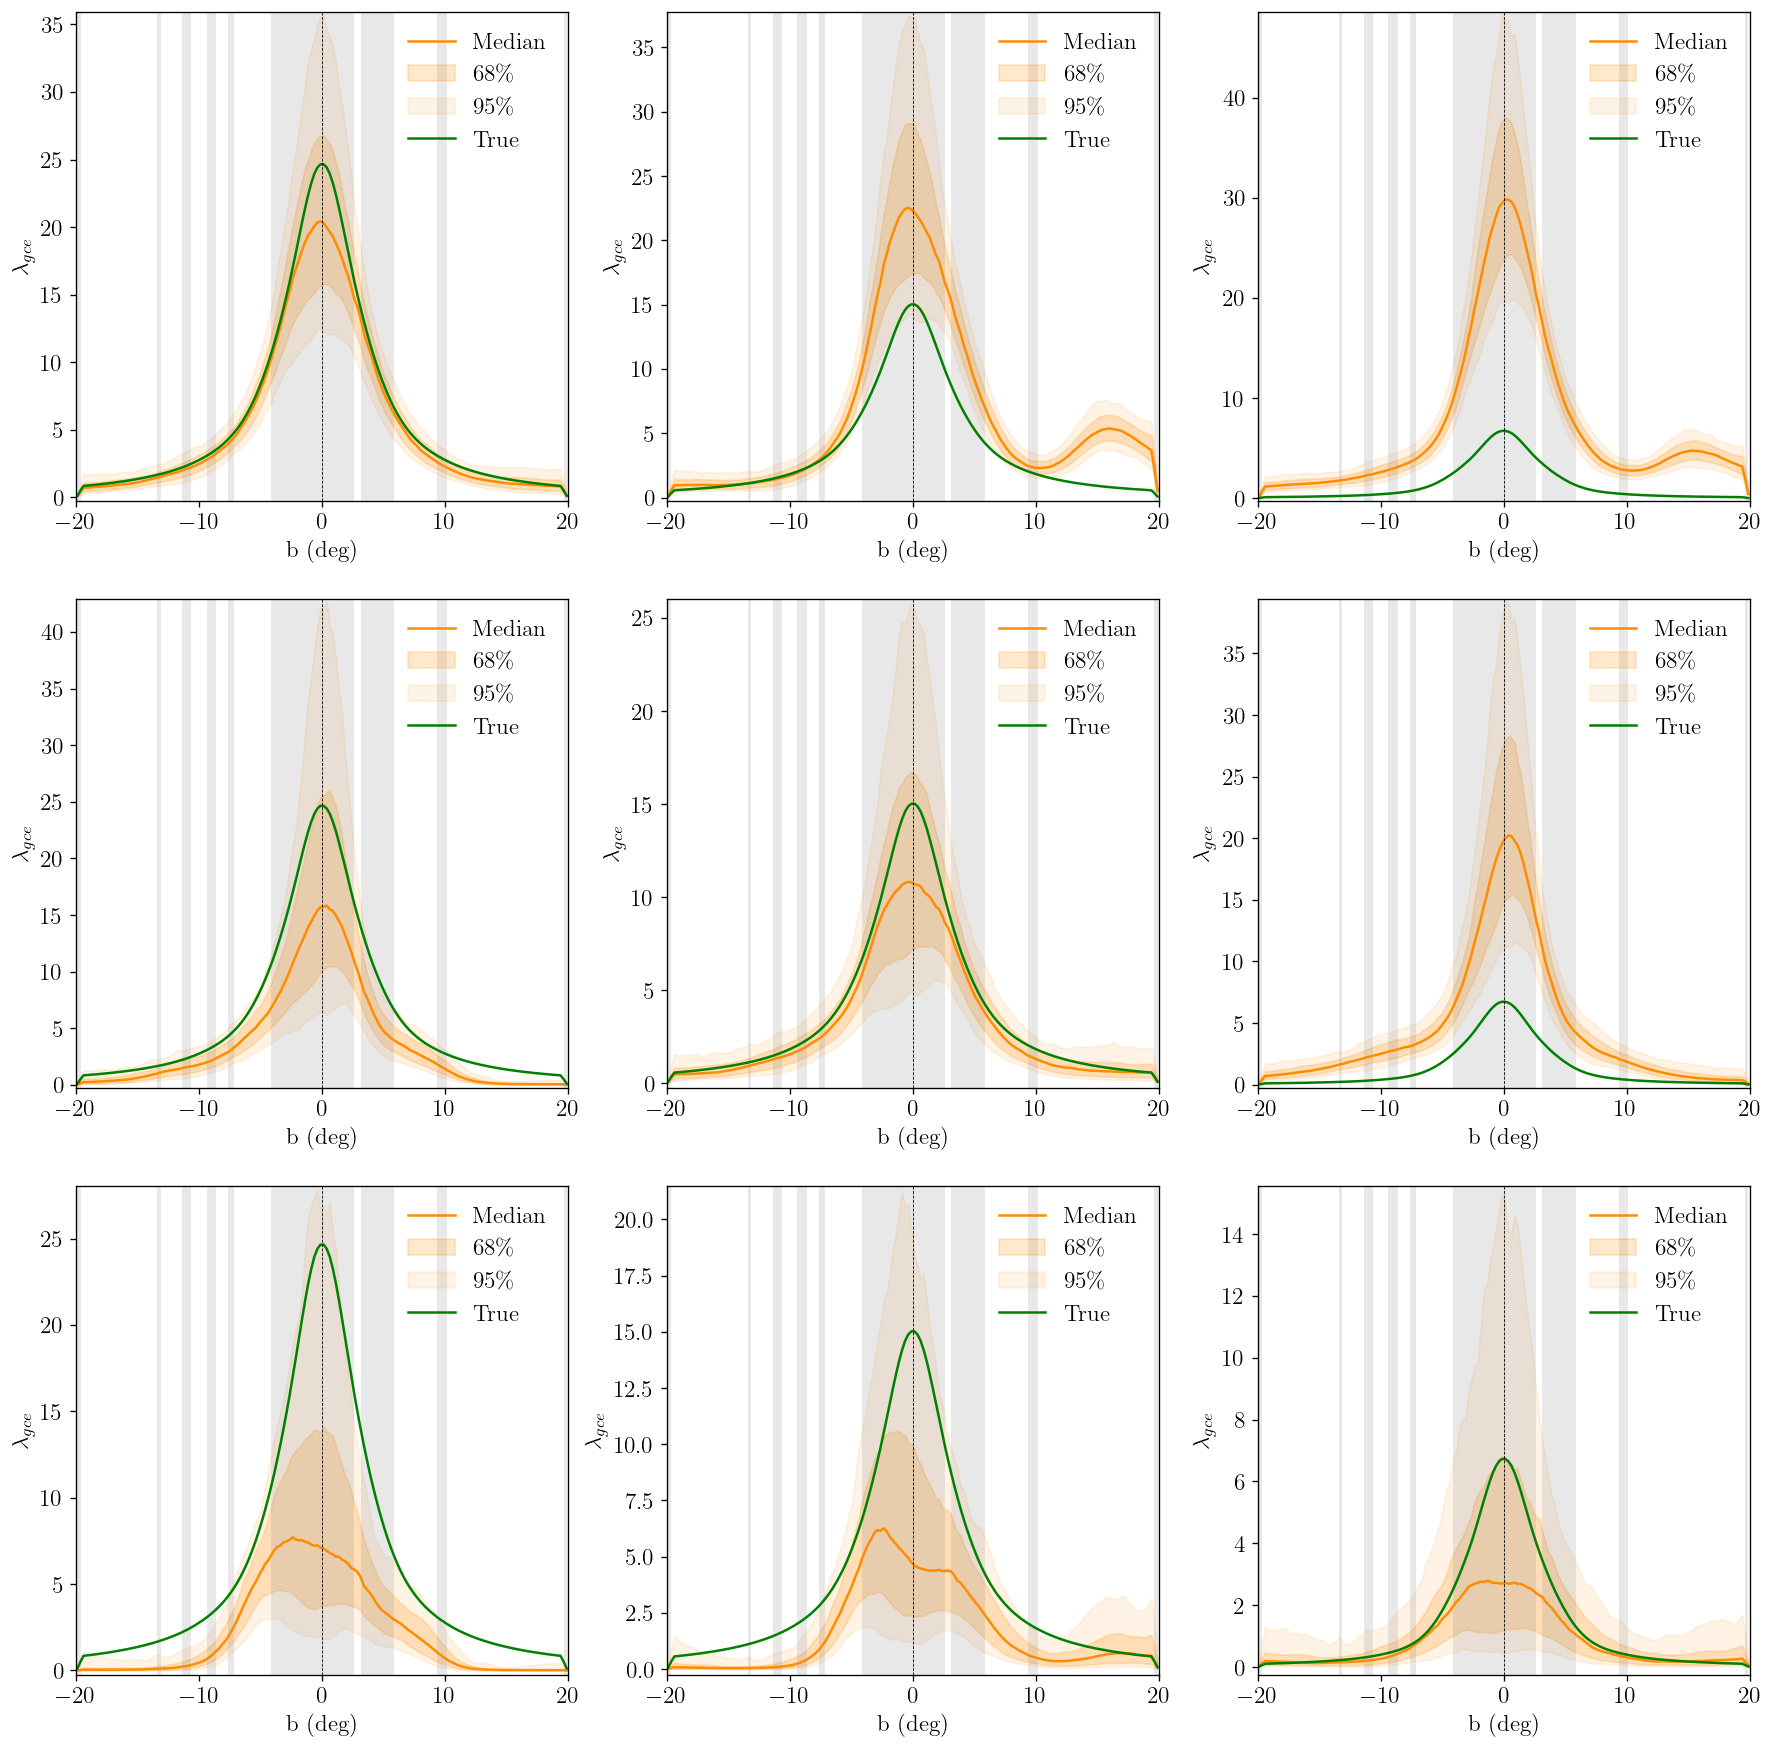

In [13]:
slice_val = 3.2  # y-value of slice

nrows = 3 ; ncols = 3
fig, axes = plt.subplots(figsize=(6*3, 6*3), dpi= 120, nrows = nrows, ncols = ncols)

for i in range(nrows):
    for j in range(ncols):
        mod_id = 10 * (i + 1) + (j + 1)

        exp_gp_samples_cart = exp_gp_samples_cart_list[mod_id]
        gp_true = gp_true_cart_list[mod_id][:5938] # contains 10 copies due to carelessness when creating this

        # 1d slice of GCE
        q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0) # cartesian sample map quantiles
        sim_cart = ef.healpix_to_cart(gp_true[:5938], mask, n_pixels = n_pixels, nside = 128) # simulated rate cartesian map
        raw_cart = None

        plt.axes(axes[i,j])
        eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
            slice_dir = 'vertical', slice_val = slice_val, 
            mask_map_cart = mask_map_cart,
            n_pixels = n_pixels,
            ylabel = '$\lambda_{gce}$', q_color = 'darkorange', line_color = 'green')

Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg
Slice at y = 3.37500 deg


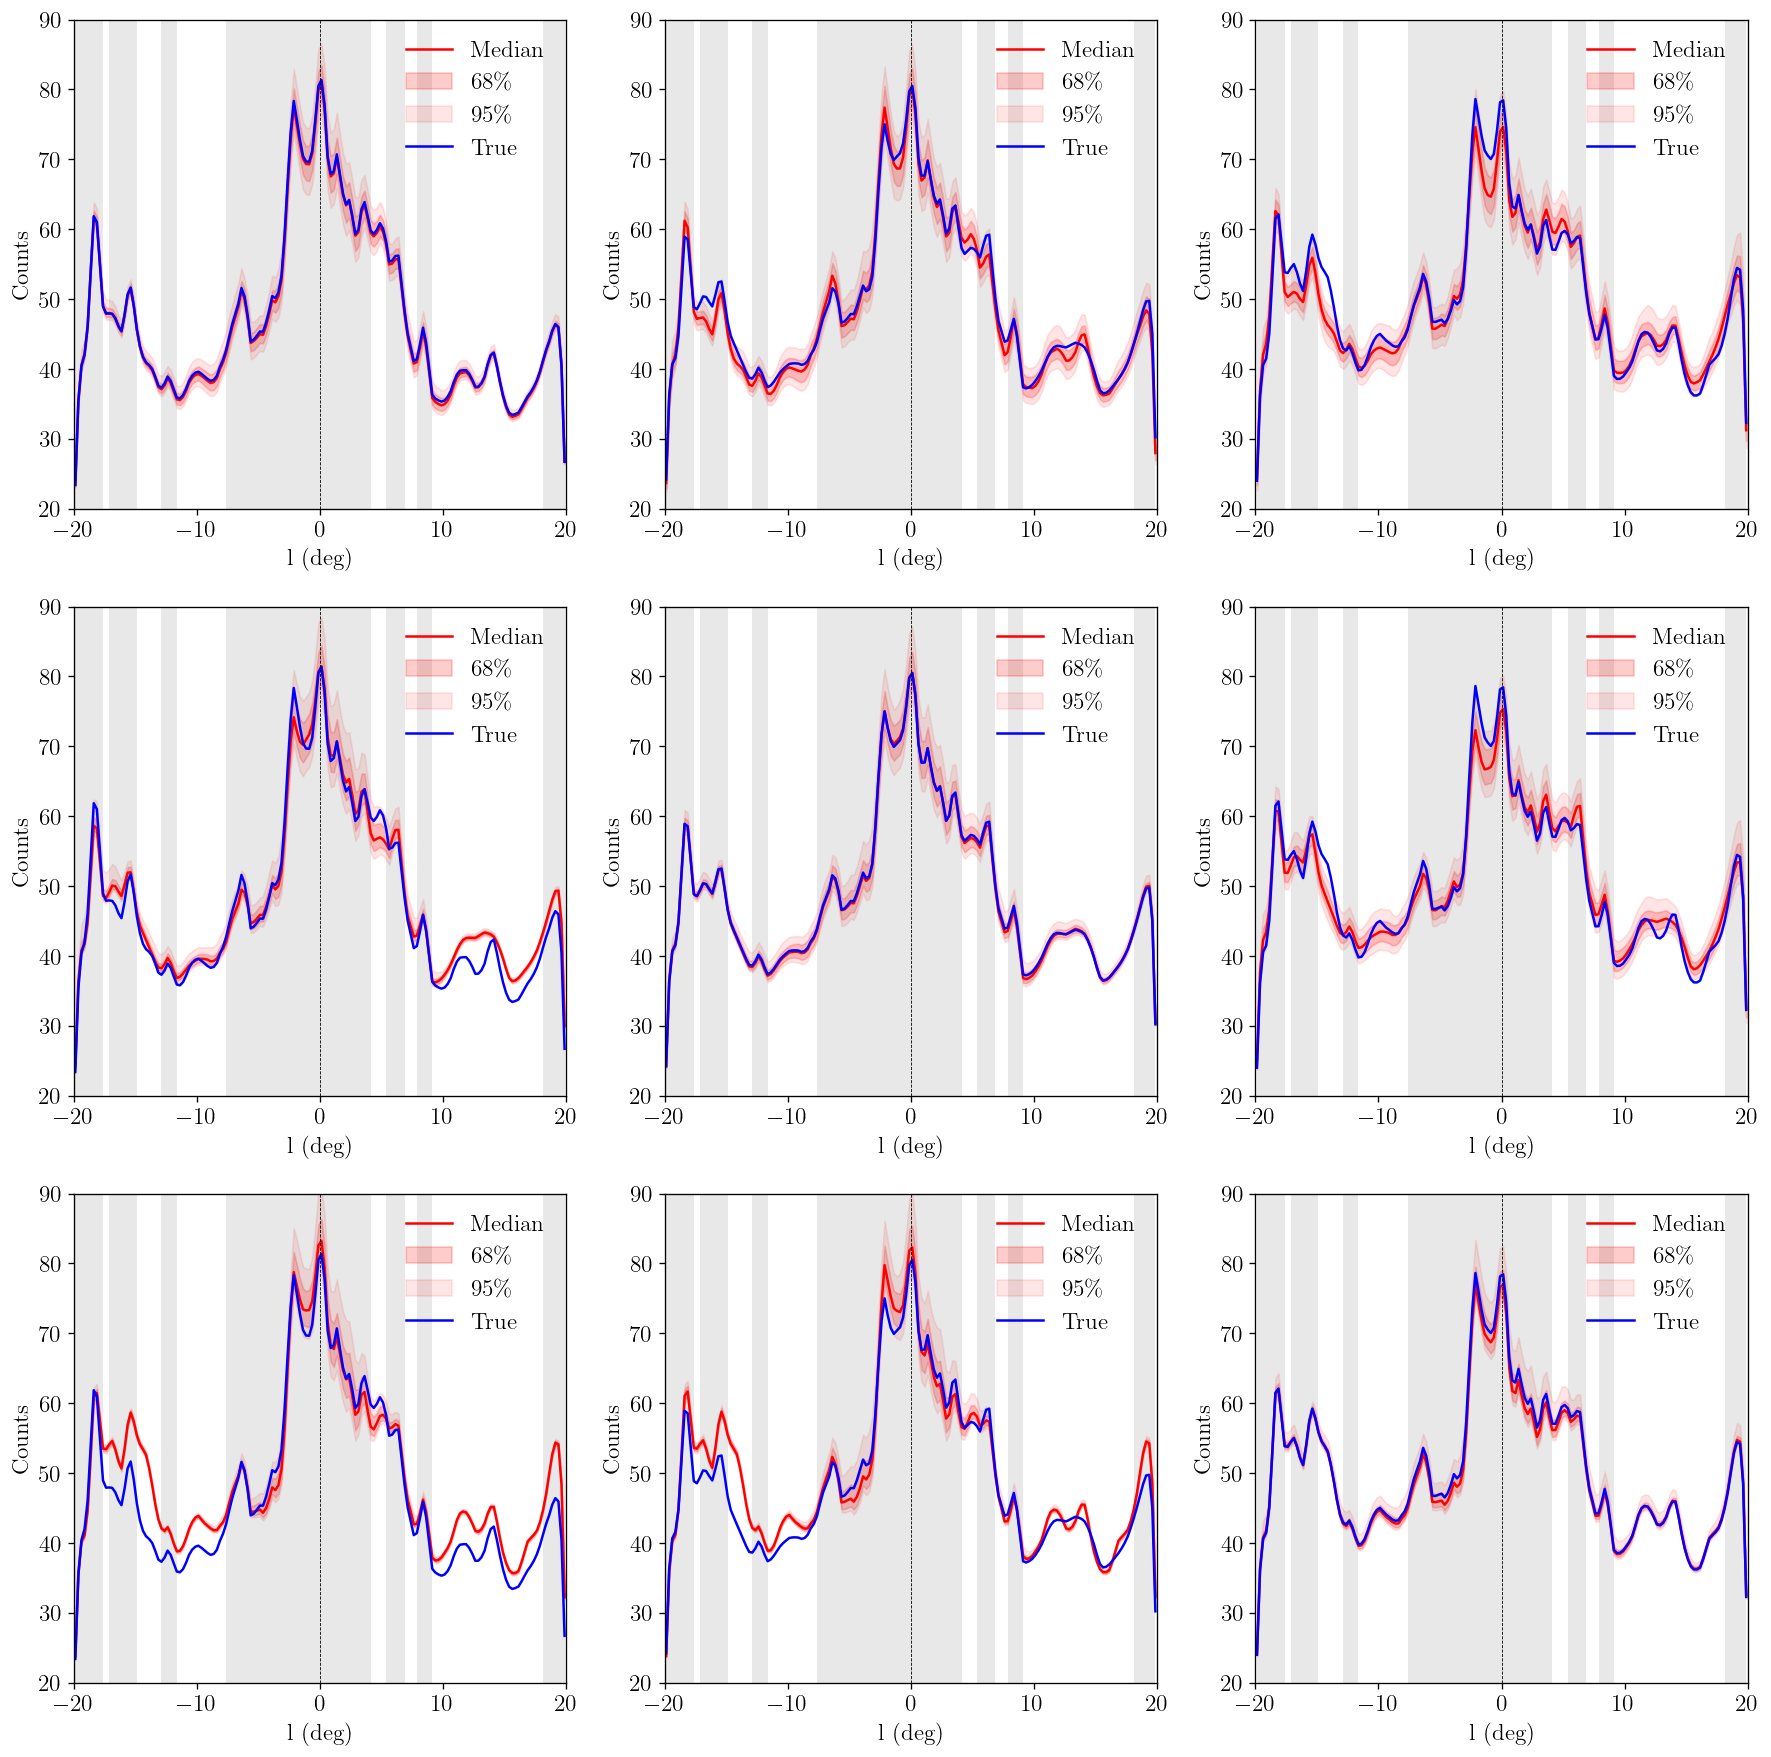

In [14]:
slice_val = 3.2  # y-value of slice

nrows = 3 ; ncols = 3
fig, axes = plt.subplots(figsize=(6*3, 6*3), dpi= 120, nrows = nrows, ncols = ncols)

for i in range(nrows):
    for j in range(ncols):
        mod_id = 10 * (i + 1) + (j + 1)

        tot_samples_cart = tot_samples_cart_list[mod_id]
        sim_cart = sim_cart_list[mod_id]

        # 1d slice of GCE
        q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
        raw_cart = None

        plt.axes(axes[i,j])
        eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
            slice_dir = 'horizontal', slice_val = slice_val, 
            ylim = [20., 90.],
            mask_map_cart = mask_map_cart,
            n_pixels = n_pixels,)

Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg
Slice at x = 3.37500 deg


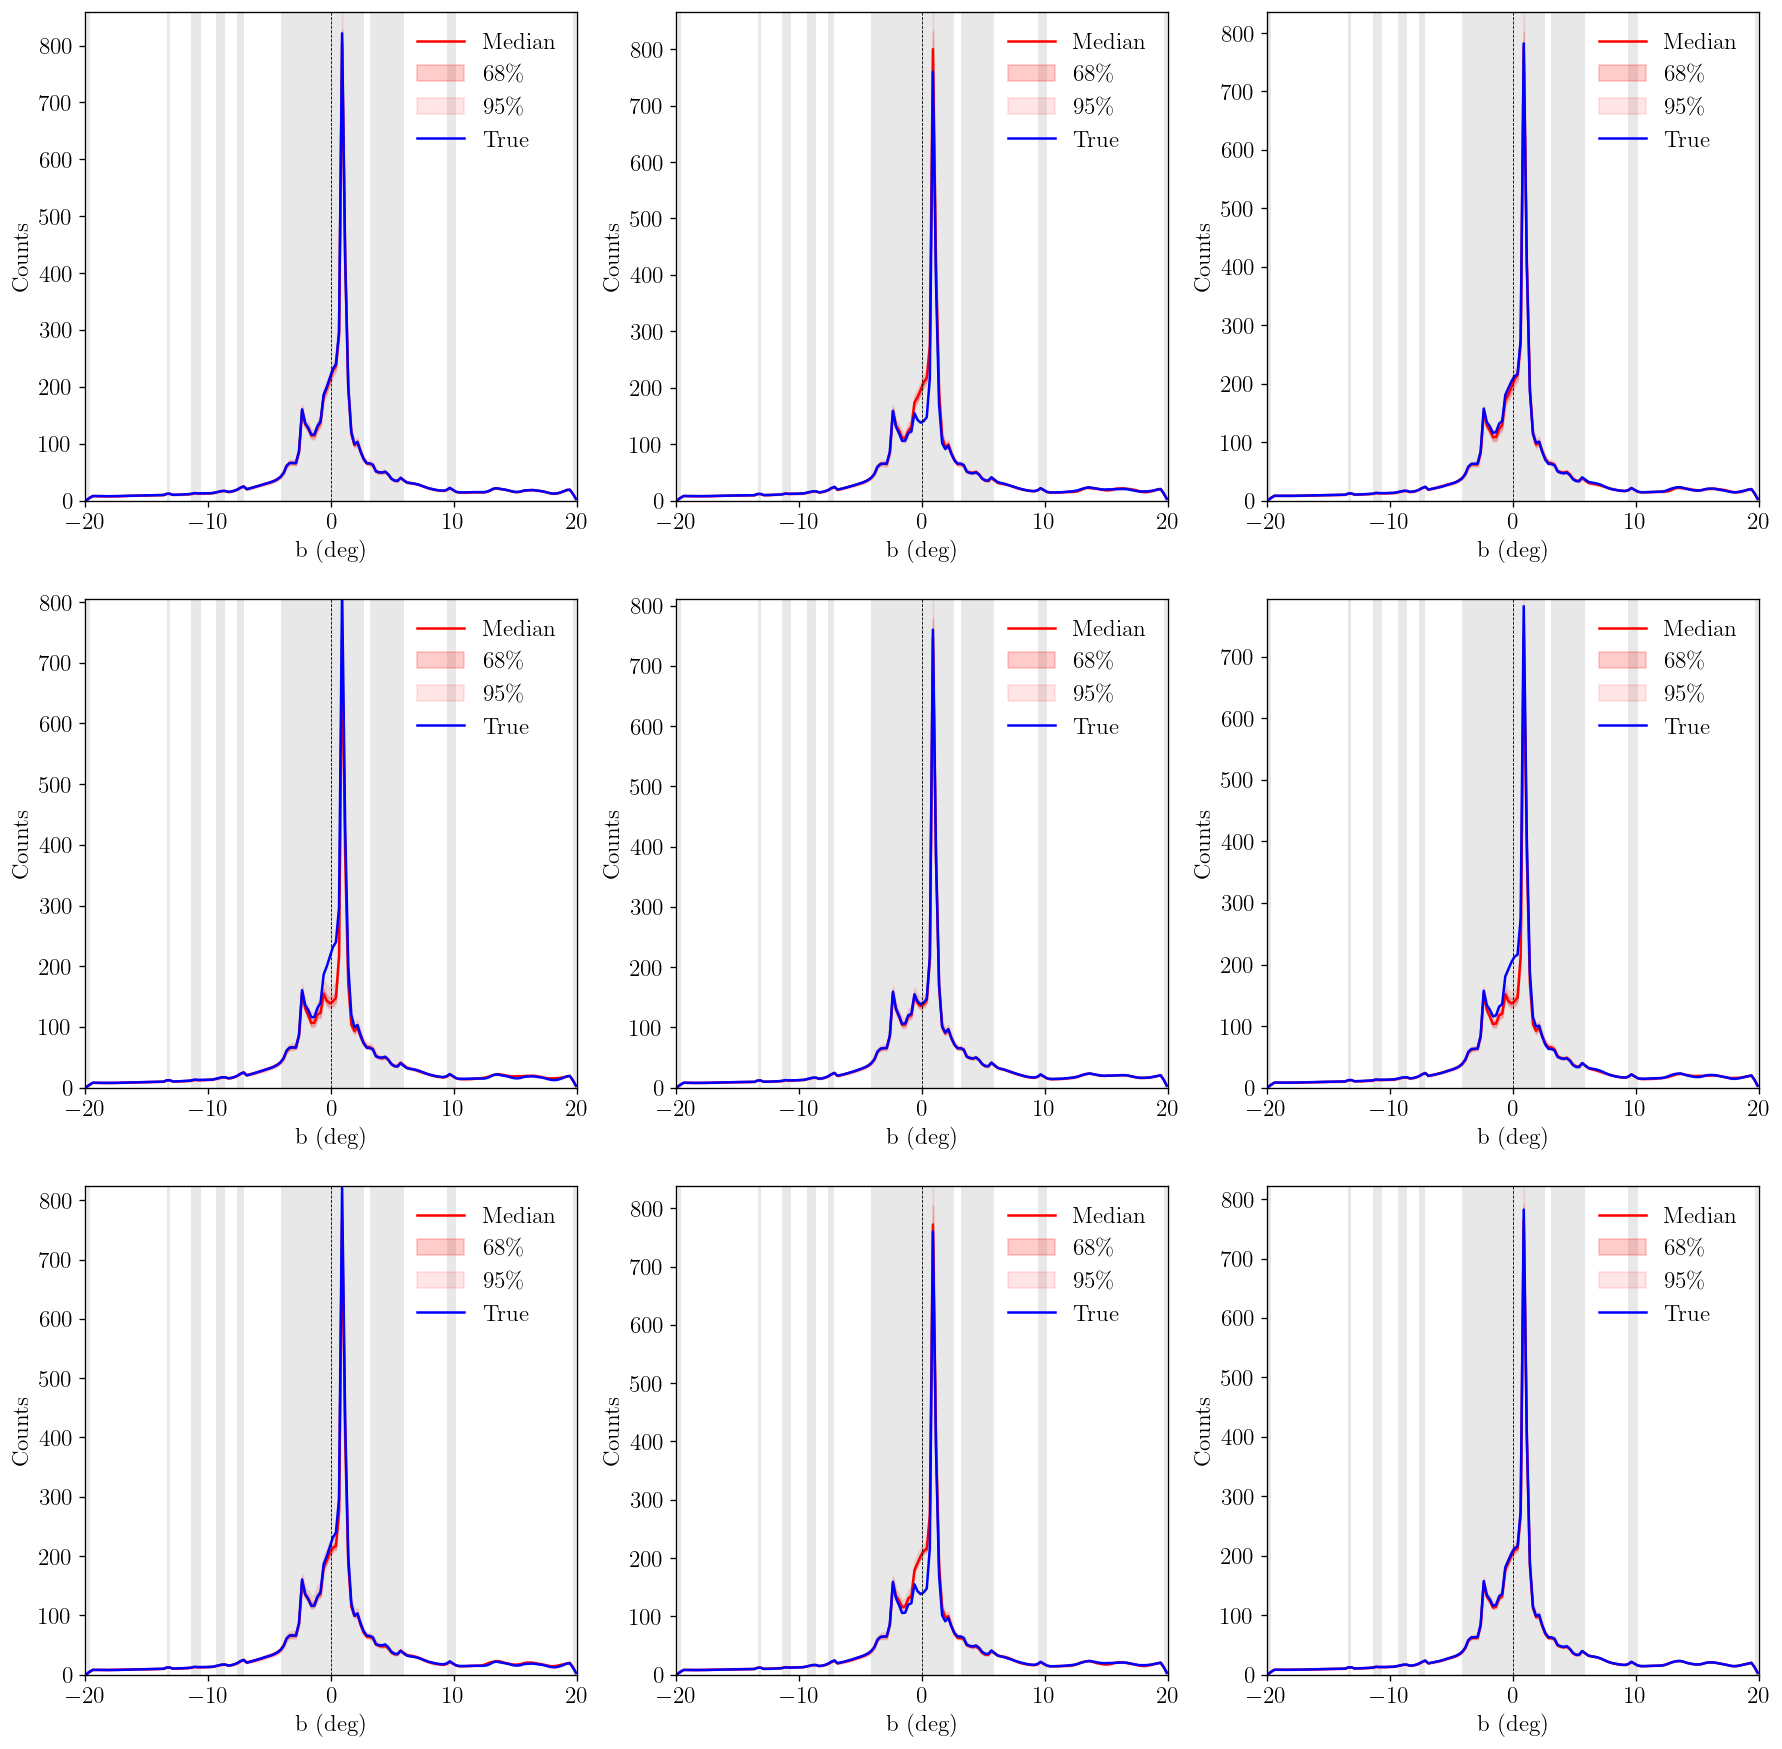

In [15]:
slice_val = 3.2  # y-value of slice

nrows = 3 ; ncols = 3
fig, axes = plt.subplots(figsize=(6*3, 6*3), dpi= 120, nrows = nrows, ncols = ncols)

for i in range(nrows):
    for j in range(ncols):
        mod_id = 10 * (i + 1) + (j + 1)

        tot_samples_cart = tot_samples_cart_list[mod_id]
        sim_cart = sim_cart_list[mod_id]

        # 1d slice of GCE
        q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
        raw_cart = None

        plt.axes(axes[i,j])
        eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
            slice_dir = 'vertical', slice_val = slice_val,
            mask_map_cart = mask_map_cart,
            n_pixels = n_pixels,)